# Deep learning for timeseries

## Different kinds of timeseries tasks

A Timeseries can be regularly obtained data from any kind of measurement, such as the hourly electricity consumption, or the use of public transport at certain times of the day, week, year etc.
The most common use-case for timeseries data is forecasting. However, there is a wide range of other things timeseries can be used for, such as classification (bot or human, given the activities on a website), event detection ("Alexa, what's the weather going to be today?"), or anomaly detection (unusual readings on a manufacturing robot).
Here, we will focus on forcasting.

## A temperature-forecasting example

We will use a dataset from the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset 14 different quantities (e.g. temperature, air humidity, atmospheric pressure, wind direction, etc.) were recorded every 10 minutes over a period of several years. We will use a subset from 2009 to 2016. Our goal will be to crate a model that can predict the temperature 24 hours in the future sufficiently accurate.

Let's begin by downloading and unzipping the data.

In [1]:
#!wget -P datasets/ https://s3.amazonaws.com/keras-data/jena_climate_2009_2016.csv.zip
#!unzip data/jena_climate_2009_2016.csv.zip -d data/jena_climate/

**Inspecting the dataset**

As you can see after executing the following cell, we have a dataset with 420451 lines of data - each line representing a timestep, containing 14 weather-related values.

In [2]:
import os
fname = os.path.join("./data/jena_climate/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

To prepare the dataset, we will create two NumPy arrays, one containing only the temperature, the other all the raw data (exept for the Data Time column). We could use Pandas to do so, but here we just use NumPy and a couple of for loops. 

In [3]:
import numpy as np

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

In [5]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Now, we make our first attempt at visualizing our data, albeit just the temperature over time.

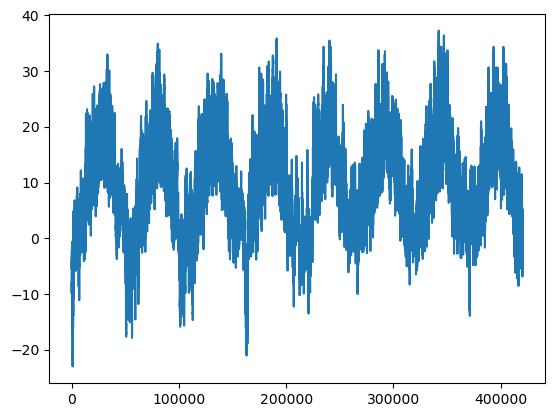

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

Wile we can already make our the yearly periodicity, this isn't really useful to predict the next 24 hours. For that we need to "zoom in".
We'll just plot the first ten days of our timeseries. As each time step is 10 minutes apart, we get 10 x 24 x 6 = 1440 data points for 10 days. 
Now we can also make out a daily periodicity. And we can see that it seems to have been a really cold winter in Jena...

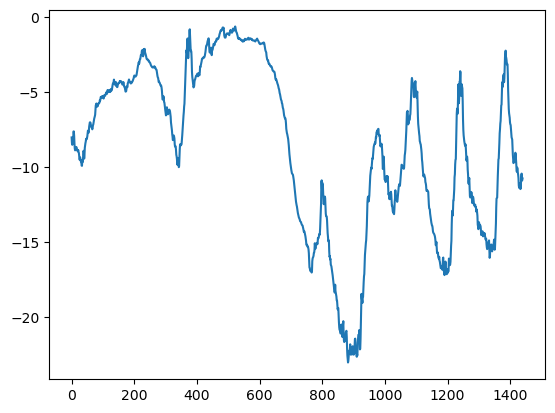

In [7]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

We will split that data manually. Of course, we could also use Scikit-Learn's API to do so, however, since we do not want random sampling in modelling timeseries data, we can just as well code it out by hand.
We will be using 50% for the training data and split the rest evenly on validation and test data.

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

Since the input data is on a very diverse scale, we will have to normalize or standardize it. In this situation we will opt for standardization, but normalization should work just as well. For that we will use the training data only.

**Standardizing the data**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

As our timeseries might be too big to load all at once, we will split it into smaller windows called sequences. There is a neat little dataset utility built into Keras called `timeseries_dataset_from_array`. To demonstrate what it does, we will use a toy dataset consisting of a NumPy array, define a `sequence_length` and a `batch_size`. Since the targets are the same as the input-data, offset by some value, we pass the same dataset to the `data` and `targets` argument. By default, `timeseries_dataset_from_array` will use the subsequent value in the dataset as target for each sequence.

In [10]:
import numpy as np
from tensorflow import keras

2025-03-31 14:25:50.479492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 14:25:50.480205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 14:25:50.480955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 14:25:50.487640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    # print(inputs, targets)
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2025-03-31 14:25:54.260168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


**Instantiating datasets for training, validation, and testing**

Now, we need to apply this keras tool to our actual dataset. This time, we would like to use hourly samples for our training data, which is why we define the `sampling_rate` to be 6. The observations should go back 5 days (120 hours), hence the value for the `sequence_lengh`. The target of a sequence will be the temperature 24 hours after the end of the sequence, which explains the variable `delay`. The samples are randomly sampled, wich means that two consecutive sequences in a batch are not necessarily temporally close.

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

Let's have a look at the shape of the resulting tuples.

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

Before we use deep learning models, let's set a baseline that we can try to beat later on with more advanced techniques (which is harder than you might think).
We will choose a very simple, common-sense approach, meaning we are assuming that tomorrow's temperature (in 24 hours) will be the same as today's (right now).
We will evaluate this approach by using the mean absolute error (MAE).

**Computing the common-sense baseline MAE**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This is actually pretty good. With our prediction we are roughly 2.5°C off target on average. That might even be better than many weather forecasts you have seen in the past.

### Let's try a basic machine-learning model

The first model we are going to use is a fully-connected dense model, with an input-layer, a flatten layer, a 16 units strong hidden layer, and an output-layer consisting of one unit. Note that we do not need an activation function at the output, as is common in other regression problems.

**Training and evaluating a densely connected model**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2025-03-31 14:26:01.988615: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f84c9242220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-31 14:26:01.988675: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-03-31 14:26:01.994162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-31 14:26:02.011307: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1743423962.075935 2640387 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


808/819 [============================>.] - ETA: 0s - loss: 11.9416 - mae: 2.6733INFO:tensorflow:Assets written to: jena_dense.tf/assets


INFO:tensorflow:Assets written to: jena_dense.tf/assets


819/819 [==============================] - 10s 10ms/step - loss: 11.9150 - mae: 2.6708 - val_loss: 10.4202 - val_mae: 2.5304
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 8.7603 - mae: 2.3292 - val_loss: 14.1843 - val_mae: 2.9976
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.1068 - mae: 2.2383 - val_loss: 11.1684 - val_mae: 2.6239
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 7.6811 - mae: 2.1793 - val_loss: 10.7352 - val_mae: 2.5778
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.3762 - mae: 2.1367 - val_loss: 10.4626 - val_mae: 2.5311
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.1359 - mae: 2.1026 - val_loss: 10.6801 - val_mae: 2.5636
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 6.9628 - mae: 2.0772 - val_loss: 10.7338 - val_mae: 2.5696
Epoch 8/10
819/819 [==============================] - 8s 10ms/step - lo

Oh, no! The model has performed worse than our naive baseline.

**Plotting results**

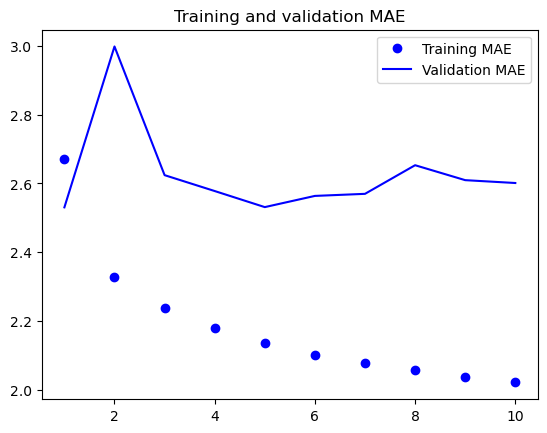

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The model also seems to be overfitting quite a bit.

### Let's try a 1D convolutional model

Now, that the fully-connected dense model has not worked that well, we could try something more complex. How about a 1D convolutional model. It works just as the 2D version, except that the sliding window is 1-dimensional.

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 22.1074 - mae: 3.6817INFO:tensorflow:Assets written to: jena_conv.tf/assets


INFO:tensorflow:Assets written to: jena_conv.tf/assets


819/819 [==============================] - 11s 11ms/step - loss: 22.1074 - mae: 3.6817 - val_loss: 17.2070 - val_mae: 3.2492
Epoch 2/10
808/819 [============================>.] - ETA: 0s - loss: 15.8823 - mae: 3.1701INFO:tensorflow:Assets written to: jena_conv.tf/assets


INFO:tensorflow:Assets written to: jena_conv.tf/assets


819/819 [==============================] - 9s 10ms/step - loss: 15.8742 - mae: 3.1699 - val_loss: 14.9139 - val_mae: 3.0457
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 14.5451 - mae: 3.0339 - val_loss: 15.3480 - val_mae: 3.0655
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 13.6292 - mae: 2.9313 - val_loss: 16.5140 - val_mae: 3.2385
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 12.9731 - mae: 2.8545 - val_loss: 15.3477 - val_mae: 3.0685
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 12.4869 - mae: 2.7957 - val_loss: 15.4494 - val_mae: 3.1214
Epoch 7/10
809/819 [============================>.] - ETA: 0s - loss: 12.0365 - mae: 2.7409INFO:tensorflow:Assets written to: jena_conv.tf/assets


INFO:tensorflow:Assets written to: jena_conv.tf/assets


819/819 [==============================] - 9s 10ms/step - loss: 12.0380 - mae: 2.7413 - val_loss: 14.2460 - val_mae: 2.9775
Epoch 8/10
819/819 [==============================] - 8s 10ms/step - loss: 11.6246 - mae: 2.6928 - val_loss: 15.3648 - val_mae: 3.1282
Epoch 9/10
819/819 [==============================] - 8s 10ms/step - loss: 11.2826 - mae: 2.6554 - val_loss: 15.1919 - val_mae: 3.0577
Epoch 10/10
405/405 [==============================] - 3s 7ms/step - loss: 15.0884 - mae: 3.0774
Test MAE: 3.08


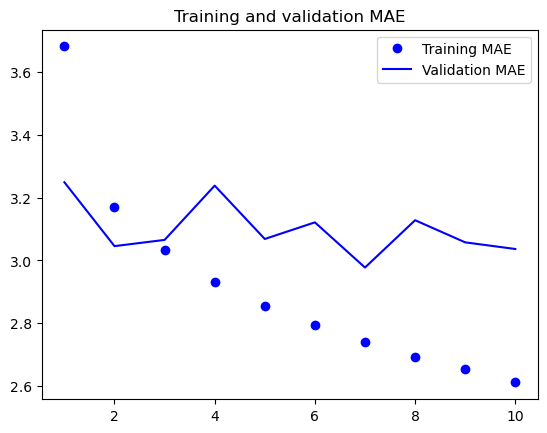

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

This one is even worse than the dense one. Why is this?
Well, there is one obvious reason: The recent past is much more important to predict tomorrow's temperature, than values from long ago. A CNN does not respect this. As a matter of fact, the same goes for the dense model, but in the CNN the pooling layers are largely destroying order information.

### A first recurrent baseline

Now, let's finally put the matter to rest and use an ANN, that is actually suited for this kind of problem. We will use a recurrent neural network (RNN) based on long-short-term-memory (LSTM) cells.
Let's see how it performs.

**A simple LSTM-based model**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
810/819 [============================>.] - ETA: 0s - loss: 35.3958 - mae: 4.3118INFO:tensorflow:Assets written to: jena_lstm.tf/assets


INFO:tensorflow:Assets written to: jena_lstm.tf/assets


819/819 [==============================] - 12s 13ms/step - loss: 35.1575 - mae: 4.2951 - val_loss: 11.9484 - val_mae: 2.6663
Epoch 2/10
813/819 [============================>.] - ETA: 0s - loss: 10.6597 - mae: 2.5403INFO:tensorflow:Assets written to: jena_lstm.tf/assets


INFO:tensorflow:Assets written to: jena_lstm.tf/assets


819/819 [==============================] - 10s 12ms/step - loss: 10.6566 - mae: 2.5400 - val_loss: 9.7913 - val_mae: 2.4270
Epoch 3/10
815/819 [============================>.] - ETA: 0s - loss: 9.7244 - mae: 2.4323INFO:tensorflow:Assets written to: jena_lstm.tf/assets


INFO:tensorflow:Assets written to: jena_lstm.tf/assets


819/819 [==============================] - 10s 12ms/step - loss: 9.7233 - mae: 2.4320 - val_loss: 9.5637 - val_mae: 2.4022
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 9.3103 - mae: 2.3753 - val_loss: 9.6566 - val_mae: 2.4170
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 8.9971 - mae: 2.3325 - val_loss: 9.9187 - val_mae: 2.4391
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 8.7352 - mae: 2.2953 - val_loss: 9.9262 - val_mae: 2.4381
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 8.5969 - mae: 2.2745 - val_loss: 9.9293 - val_mae: 2.4352
Epoch 8/10
819/819 [==============================] - 9s 11ms/step - loss: 8.4870 - mae: 2.2566 - val_loss: 10.6567 - val_mae: 2.4853
Epoch 9/10
819/819 [==============================] - 8s 10ms/step - loss: 8.3403 - mae: 2.2361 - val_loss: 10.6111 - val_mae: 2.4920
Epoch 10/10
405/405 [==============================] - 3s 7ms/step - loss: 10

Now we're talking! We could, of course, still improve on this simple model.

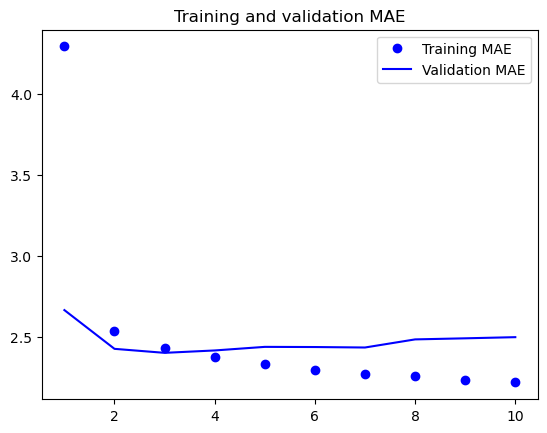

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [22]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [23]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [26]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

Here we are using dropout layers to force the RNN to regularize. There are two forms of dropout that can be used in RNNs. The first one in use is the recurrent_dropout, which only works among recurrent units, the other form is the one we've already come across, which "switches off" a specified amount of connections between layers.
As models with dropout built into them tend to converge much slower, we need to train for quite a bit longer. Additionally, we have the issue here, that cuDNN kernels will not be used (unless we stick to a vanilla setup), making this model painfully slow to train. In Fact, as our sequence length is quite short, we would probably be better off training this model on the CPUs only.
Another way to cut training time, is to unroll the model, meaning, we unroll the underlying for loops, making it easier for TensorFlow to create the computational graph. However, this will increase your memory usage.

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - ETA: 0s - loss: 26.7029 - mae: 3.8139INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


819/819 [==============================] - 155s 185ms/step - loss: 26.7029 - mae: 3.8139 - val_loss: 9.6522 - val_mae: 2.4091
Epoch 2/50
819/819 [==============================] - ETA: 0s - loss: 14.8421 - mae: 2.9920INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


819/819 [==============================] - 152s 185ms/step - loss: 14.8421 - mae: 2.9920 - val_loss: 9.4700 - val_mae: 2.3839
Epoch 3/50
819/819 [==============================] - ETA: 0s - loss: 13.8937 - mae: 2.8955INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


819/819 [==============================] - 152s 186ms/step - loss: 13.8937 - mae: 2.8955 - val_loss: 9.1903 - val_mae: 2.3493
Epoch 4/50
819/819 [==============================] - ETA: 0s - loss: 13.3374 - mae: 2.8367INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


819/819 [==============================] - 152s 186ms/step - loss: 13.3374 - mae: 2.8367 - val_loss: 9.0649 - val_mae: 2.3395
Epoch 5/50
819/819 [==============================] - 151s 185ms/step - loss: 12.8392 - mae: 2.7839 - val_loss: 9.1294 - val_mae: 2.3468
Epoch 6/50
819/819 [==============================] - 150s 184ms/step - loss: 12.4934 - mae: 2.7431 - val_loss: 9.1956 - val_mae: 2.3574
Epoch 7/50
819/819 [==============================] - 151s 184ms/step - loss: 12.2608 - mae: 2.7174 - val_loss: 9.1389 - val_mae: 2.3521
Epoch 8/50
819/819 [==============================] - 151s 184ms/step - loss: 11.9583 - mae: 2.6862 - val_loss: 9.1629 - val_mae: 2.3422
Epoch 9/50
819/819 [==============================] - 150s 183ms/step - loss: 11.7617 - mae: 2.6638 - val_loss: 9.3368 - val_mae: 2.3714
Epoch 10/50
819/819 [==============================] - 151s 184ms/step - loss: 11.5716 - mae: 2.6439 - val_loss: 9.3181 - val_mae: 2.3783
Epoch 11/50
819/819 [==============================

INFO:tensorflow:Assets written to: jena_lstm_dropout.tf/assets


819/819 [==============================] - 151s 185ms/step - loss: 11.0411 - mae: 2.5792 - val_loss: 9.0596 - val_mae: 2.3311
Epoch 15/50
819/819 [==============================] - 149s 182ms/step - loss: 10.8994 - mae: 2.5632 - val_loss: 9.2923 - val_mae: 2.3586
Epoch 16/50
819/819 [==============================] - 150s 183ms/step - loss: 10.8133 - mae: 2.5520 - val_loss: 9.0753 - val_mae: 2.3266
Epoch 17/50
819/819 [==============================] - 149s 182ms/step - loss: 10.6568 - mae: 2.5328 - val_loss: 9.5394 - val_mae: 2.4008
Epoch 18/50
819/819 [==============================] - 149s 182ms/step - loss: 10.5674 - mae: 2.5230 - val_loss: 9.3116 - val_mae: 2.3654
Epoch 19/50
819/819 [==============================] - 151s 183ms/step - loss: 10.5351 - mae: 2.5157 - val_loss: 9.5253 - val_mae: 2.3999
Epoch 20/50
819/819 [==============================] - 150s 183ms/step - loss: 10.4634 - mae: 2.5061 - val_loss: 9.3950 - val_mae: 2.3726
Epoch 21/50
819/819 [=========================

405/405 [==============================] - 13s 31ms/step - loss: 10.0335 - mae: 2.5020
Test MAE: 2.50


Let's try the same thing on the CPUs. To save time, we will reduce the number of epochs to 5.

In [28]:
import tensorflow as tf

In [29]:
with tf.device('/CPU:0'):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    callbacks = [
        keras.callbacks.ModelCheckpoint("jena_lstm_dropout_cpu.tf",
                                    save_best_only=True)
    ]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

    model = keras.models.load_model("jena_lstm_dropout_cpu.tf")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
  3/819 [..............................] - ETA: 49s - loss: 156.4061 - mae: 10.4026  

2025-03-31 16:36:00.988119: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f84f4124ed0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-31 16:36:00.988423: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-31 16:36:01.034771: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-03-31 16:36:01.039144: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-03-31 16:36:01.105169: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


818/819 [============================>.] - ETA: 0s - loss: 29.2078 - mae: 3.9820INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


819/819 [==============================] - 66s 68ms/step - loss: 29.2002 - mae: 3.9815 - val_loss: 9.7682 - val_mae: 2.4340
Epoch 2/5
818/819 [============================>.] - ETA: 0s - loss: 14.8603 - mae: 2.9900INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


819/819 [==============================] - 56s 68ms/step - loss: 14.8600 - mae: 2.9900 - val_loss: 9.5812 - val_mae: 2.4108
Epoch 3/5
818/819 [============================>.] - ETA: 0s - loss: 13.8221 - mae: 2.8791INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


819/819 [==============================] - 56s 68ms/step - loss: 13.8226 - mae: 2.8792 - val_loss: 9.4247 - val_mae: 2.3883
Epoch 4/5
818/819 [============================>.] - ETA: 0s - loss: 13.1137 - mae: 2.8061INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


819/819 [==============================] - 56s 68ms/step - loss: 13.1143 - mae: 2.8061 - val_loss: 9.3905 - val_mae: 2.3853
Epoch 5/5
818/819 [============================>.] - ETA: 0s - loss: 12.6629 - mae: 2.7527INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout_cpu.tf/assets


819/819 [==============================] - 57s 69ms/step - loss: 12.6635 - mae: 2.7528 - val_loss: 9.1294 - val_mae: 2.3502


405/405 [==============================] - 7s 17ms/step - loss: 10.0401 - mae: 2.4960
Test MAE: 2.50


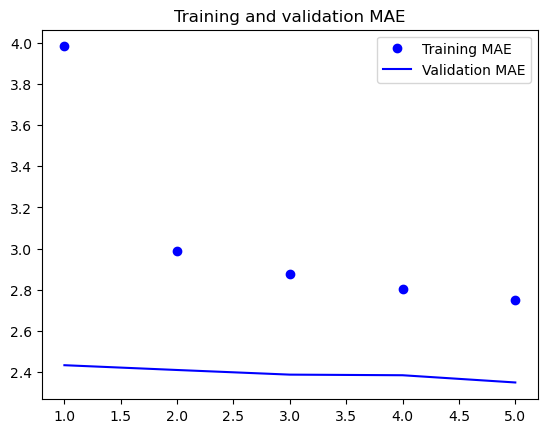

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("images/jena_cpu_50_epochs.png")
plt.show()

<figure>
<img src="images/jena_cpu_50_epochs.png" alt="LSTM with dropout" width=700>
<figcaption>LSTM with dropout, trained for 50 epochs.</figcaption>
</figure>
Quite a bit faster, but no dramatic improvement in terms of MAE. However, we ran in to overfitting much later, at around epoch 20.

The unrolled version on the GPUs should look like the cell down below. However, there is a bug in the TensorFlow version being used, which is why this will run into an error about the input shape (the input expects a fixed length of timesteps....).

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]), batch_size=256)
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout_unrolled.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout_unrolled.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50


ValueError: in user code:

    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/gpfs/opt/sw/jupyterhub/envs/conda/vsc5/jupyterhub-huggingface-v2/lib/python3.10/site-packages/keras/src/backend.py", line 4856, in rnn
        raise ValueError("Unrolling requires a fixed number of timesteps.")

    ValueError: Exception encountered when calling layer 'lstm_3' (type LSTM).
    
    Unrolling requires a fixed number of timesteps.
    
    Call arguments received by layer 'lstm_3' (type LSTM):
      • inputs=tf.Tensor(shape=(None, None, 14), dtype=float32)
      • mask=None
      • training=True
      • initial_state=None


### Stacking recurrent layers

As long as we do not have an overfitting situation, we can increase the model capacity, meaning we can increase the number of layers and units per layer. If we do that with RNNs, we need to make sure to set the argument `return_sequences` to True, since every recurrent layer expects a rank 3 tensor (full sequence of outputs) and not just the output for the last timestep.
Here, we are also using dropout-layers to keep overfitting in check. Instead of LSTM cells we are using GRU (gated recurrent unit) cells, which are a more streamlined version of LSTM (but very similar).

**Training and evaluating a dropout-regularized, stacked GRU model**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - ETA: 0s - loss: 27.3420 - mae: 3.8400INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


819/819 [==============================] - 288s 349ms/step - loss: 27.3420 - mae: 3.8400 - val_loss: 9.3874 - val_mae: 2.3581
Epoch 2/50
819/819 [==============================] - ETA: 0s - loss: 14.1142 - mae: 2.9103INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


819/819 [==============================] - 286s 349ms/step - loss: 14.1142 - mae: 2.9103 - val_loss: 9.2372 - val_mae: 2.3596
Epoch 3/50
819/819 [==============================] - ETA: 0s - loss: 13.2735 - mae: 2.8223INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf/assets


819/819 [==============================] - 286s 349ms/step - loss: 13.2735 - mae: 2.8223 - val_loss: 8.7588 - val_mae: 2.2970
Epoch 4/50
819/819 [==============================] - 283s 345ms/step - loss: 12.6955 - mae: 2.7623 - val_loss: 9.0156 - val_mae: 2.3266
Epoch 5/50
819/819 [==============================] - 282s 345ms/step - loss: 12.2468 - mae: 2.7104 - val_loss: 9.0760 - val_mae: 2.3427
Epoch 6/50
819/819 [==============================] - 282s 344ms/step - loss: 11.8190 - mae: 2.6675 - val_loss: 8.7672 - val_mae: 2.2999
Epoch 7/50
819/819 [==============================] - 282s 344ms/step - loss: 11.4198 - mae: 2.6205 - val_loss: 9.0930 - val_mae: 2.3397
Epoch 8/50
819/819 [==============================] - 283s 345ms/step - loss: 11.1773 - mae: 2.5954 - val_loss: 8.9567 - val_mae: 2.3247
Epoch 9/50
819/819 [==============================] - 283s 345ms/step - loss: 10.8220 - mae: 2.5529 - val_loss: 9.0240 - val_mae: 2.3303
Epoch 10/50
819/819 [==============================]

405/405 [==============================] - 24s 58ms/step - loss: 9.5927 - mae: 2.4249
Test MAE: 2.42


### Using bidirectional RNNs

On certain tasks bidirectional RNNs can outperform unidirectional RNNs (what we've been using so far). RNNs generally work well on data where order is relevant, which is why we have been using them on our temperature example. A bidirectional RNN uses two regular RNNs, where one processes the sequence in one direction and the other in the reverse direction. By doing so a bidirectional RNN can catch patterns that may be overlooked in a unidirectional RNN.
However, in our example the bidirectional RNN will perform relatively poorly. This is because in our use-case the more recent entries of a sequence are more relevant for the prediction than older ones. Since a bidirectional RNN also reverses the order, this does not make a lot of sense here. Bidirectional RNNs shine in situations where order matters, but not which order you use, such as natural language processing. In fact, until the rise of the transformer architecture in 2017, bidirectional RNNs were seen as state-of-the-art for NLP tasks.
To show you how to use this architecture in Keras, we will nonetheless apply it on our temperature example below.

**Training and evaluating a bidirectional LSTM**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 27.5774 - mae: 3.7585 - val_loss: 10.0597 - val_mae: 2.4704
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.2899 - mae: 2.3752 - val_loss: 9.6952 - val_mae: 2.4252
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 8.2105 - mae: 2.2322 - val_loss: 10.1286 - val_mae: 2.4730
Epoch 4/10
819/819 [==============================] - 10s 13ms/step - loss: 7.6980 - mae: 2.1629 - val_loss: 9.6934 - val_mae: 2.4041
Epoch 5/10
819/819 [==============================] - 10s 13ms/step - loss: 7.3615 - mae: 2.1133 - val_loss: 9.8460 - val_mae: 2.4357
Epoch 6/10
819/819 [==============================] - 10s 13ms/step - loss: 7.0892 - mae: 2.0742 - val_loss: 10.3093 - val_mae: 2.4840
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 6.8777 - mae: 2.0404 - val_loss: 10.2899 - val_mae: 2.4855
Epoch 8/10
819/819 [==============================] - 10s

### Going further

You could of course try the following:
- Adjust the number of units
- Adjust the amount of dropout
- Adjust the learning rate
- Try a different optimizer
- Use a stack of dense layers on top
- Experiment with the sequence length
- ......
- ...
- .